# Utilización, procesamiento y visualización de grandes volúmenes de datos

### Diego Isaac Fuentes Juvera A01705506




## **Revisión de los datos**

Para este proyecto utilicé el dataset de 'Daily Market Prices of Commodity India (2001-2025)', descargado desde kaggle: https://www.kaggle.com/datasets/khandelwalmanas/daily-commodity-prices-india

Este dataset cuenta con datos sobre bienes vendidos en india desde enero del 2001 hasta mayo del 2025, e incluye datos de la ubicación, el tipo de bien, la variedad, el grado, la fecha de llegada, el precio (máximo, mínimo, y modal)., e identificadores únicos para cada bien. El dataset contiene más de 75 millones de registros de 374 bienes únicos y 1504 variedades. Los datos fueron obtenidos de 'mandis' o mercados locales en India.

El dataset completo tiene un peso de más de 5 GB, pero por limitaciones de espacio en drive y por la tardanza al procesar los datos lo limité a los años de 2012 a 2019. El dataset reducido pesa alrededor de 2 GB.


Mi objetivo con este dataset fue predecir el precio de las naranjas.


## **Ambiente de PySpark**

Lo primero que hice fue instalar las librerías necesarias y crear mi sesión de spark, luego conecté el notebook a mi unidad de drive para poder cargar el dataset.

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jre-headless_11.0.28%2b6-1ubuntu1%7e22.04.1_amd64.deb  404  Not Found [IP: 91.189.91.81 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jdk-headless_11.0.28%2b6-1ubuntu1%7e22.04.1_amd64.deb  404  Not Found [IP: 91.189.91.81 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
tar: spark-3.4.1-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Market Prices Analysis').getOrCreate()
spark

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
#put your own path in google drive
%cd "/content/gdrive/MyDrive/Uni/SeptimoSem/Datasets/IndiaMarketPrices"
!ls

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Uni/SeptimoSem/Datasets/IndiaMarketPrices'
/content
gdrive	sample_data


## **Carga del dataset**


Cargué el dataset a partir de varios archivos anuales en formato CSV en un solo dataframe.

In [ ]:
df = spark.read.csv('/content/gdrive/MyDrive/Uni/SeptimoSem/Big Data/Proyecto/IndiaMarketPrices', header=True, inferSchema = True)
df.show(10)


+--------------+---------+-----------+--------------------+---------------+------+------------+---------+---------+-----------+--------------+
|         State| District|     Market|           Commodity|        Variety| Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|
+--------------+---------+-----------+--------------------+---------------+------+------------+---------+---------+-----------+--------------+
|Andhra Pradesh|Anantapur|  Anantapur|     Ground Nut Seed|Ground Nut Seed|Medium|  2012-01-01|   4400.0|   4500.0|     4450.0|           268|
|Andhra Pradesh|Anantapur|  Anantapur|           Groundnut|          Local|Medium|  2012-01-01|   3400.0|   3500.0|     3450.0|            10|
|Andhra Pradesh|Anantapur|Dharmavaram|           Groundnut|          Local|Medium|  2012-01-01|   2900.0|   3000.0|     2950.0|            10|
|Andhra Pradesh|Anantapur|Dharmavaram|Paddy (Dhan)(Common)|          B P T|Medium|  2012-01-01|   1000.0|   1030.0|     1015.0|             2|

In [ ]:
df.show(10)

+--------------+---------+-----------+--------------------+---------------+------+------------+---------+---------+-----------+--------------+
|         State| District|     Market|           Commodity|        Variety| Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|
+--------------+---------+-----------+--------------------+---------------+------+------------+---------+---------+-----------+--------------+
|Andhra Pradesh|Anantapur|  Anantapur|     Ground Nut Seed|Ground Nut Seed|Medium|  2012-01-01|   4400.0|   4500.0|     4450.0|           268|
|Andhra Pradesh|Anantapur|  Anantapur|           Groundnut|          Local|Medium|  2012-01-01|   3400.0|   3500.0|     3450.0|            10|
|Andhra Pradesh|Anantapur|Dharmavaram|           Groundnut|          Local|Medium|  2012-01-01|   2900.0|   3000.0|     2950.0|            10|
|Andhra Pradesh|Anantapur|Dharmavaram|Paddy (Dhan)(Common)|          B P T|Medium|  2012-01-01|   1000.0|   1030.0|     1015.0|             2|

In [ ]:
df.describe()

DataFrame[summary: string, State: string, District: string, Market: string, Commodity: string, Variety: string, Grade: string, Min_Price: string, Max_Price: string, Modal_Price: string, Commodity_Code: string]

Para esta regresión elegí predecir el precio de las naranjas, por lo que filtré el dataframe para quedarme con todos los datos con código 18 (El código de las naranjas).

In [ ]:
orange_df = df.filter(df.Commodity_Code == 18)
display(orange_df.show())

+----------------+--------------------+--------------------+---------+-------+------+------------+---------+---------+-----------+--------------+
|           State|            District|              Market|Commodity|Variety| Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|
+----------------+--------------------+--------------------+---------+-------+------+------------+---------+---------+-----------+--------------+
|  Andhra Pradesh|           Anantapur|           Tadipatri|   Orange| Orange|Medium|  2012-01-01|   1300.0|   1400.0|     1350.0|            18|
|  Andhra Pradesh|            Cuddapah|         Pulivendala|   Orange| Medium|Medium|  2012-01-01|   1000.0|   1500.0|     1200.0|            18|
|         Gujarat|   Vadodara (Baroda)| Vadodara (Navapura)|   Orange|  Other|Medium|  2012-01-01|   1700.0|   2200.0|     2100.0|            18|
|         Haryana|              Jhajar|         Bahadurgarh|   Orange|  Other| Small|  2012-01-01|   2000.0|   2500.0|     2

None

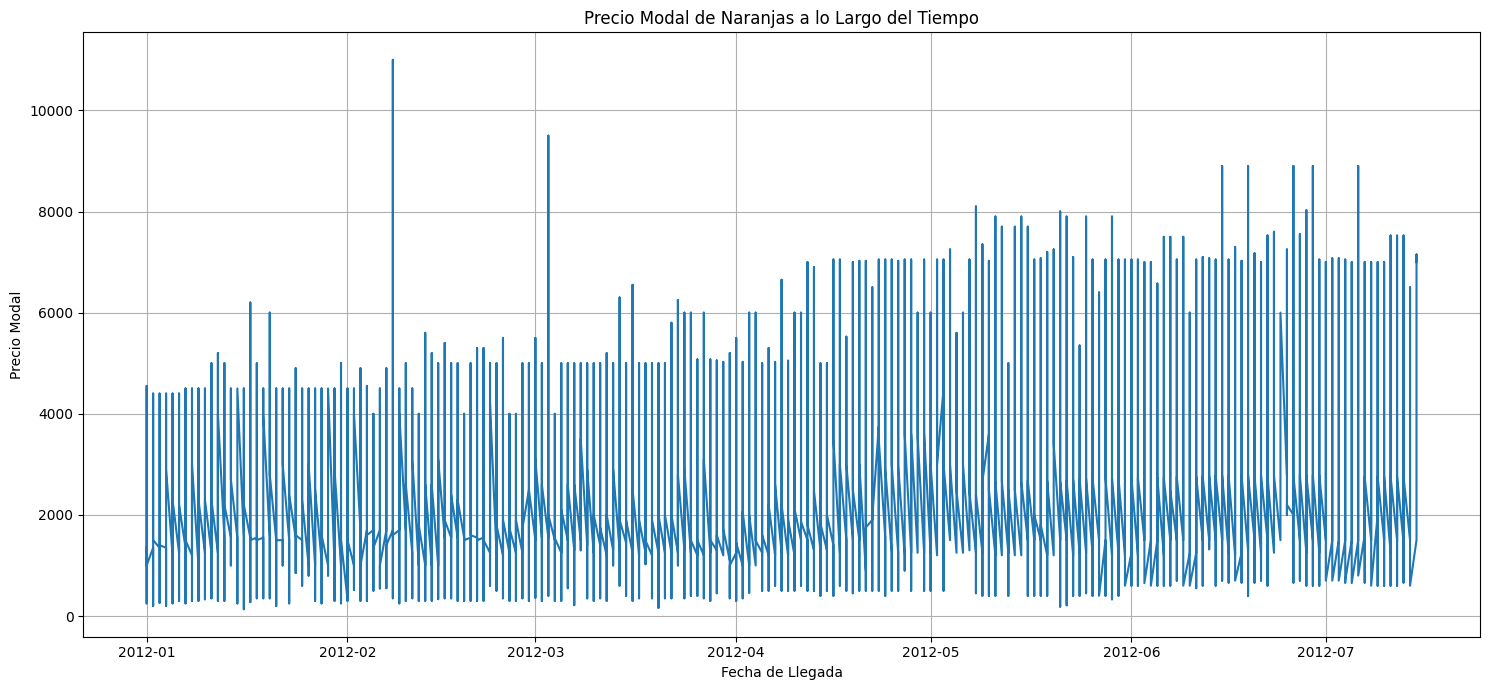

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir el DataFrame de Spark a Pandas para la visualización, tomando una muestra para eficiencia
# y ordenando por fecha para la visualización de series de tiempo
orange_df_sample = orange_df.select("Arrival_Date", "Modal_Price").orderBy("Arrival_Date").limit(10000).toPandas()

plt.figure(figsize=(15, 7))
plt.plot(orange_df_sample["Arrival_Date"], orange_df_sample["Modal_Price"])
plt.title("Precio Modal de Naranjas a lo Largo del Tiempo")
plt.xlabel("Fecha de Llegada")
plt.ylabel("Precio Modal")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Análisis cuantitativo**

Para estudiar el dataset obtuve los valores únicos de las columnas categóricas, lo que me hizo darme cuenta que las variables de ubicación (Distrito, mercado, y estado) tenían muchos posibles valores (más de 15), mientras que grado y variedad tenían una cantidad más manejable con 5 y 8 respectivamente.

(Tarda mucho en ejecutar y decidí saltarme esto al volver a ejecutar el notebook, por eso el output de la celda no es correcto)

In [ ]:
from pyspark.sql.functions import col

columns_to_show = ['Variety', 'Grade', 'District', 'Market', 'State']

for column in columns_to_show:
  print(f"Unique values for {column}:")
  orange_df.select(col(column)).distinct().show()

Unique values for Variety:


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

Al tratar de hacer one-hot encodding a las variables categóricas de ubicación y de variedad tuve muchos problemas, entre ellos que tardaba más de 1 hora en procesarse todo el dataset por variable y que se generaban demasiadas columnas, por lo que decidí quitar estas columnas de la regresión. También quite la columna de 'commodity' al ser solo un identificador de las naranjas.

In [ ]:
columns_to_drop = ['District', 'Market', 'State', 'Variety', 'Commodity']
orange_df = orange_df.drop(*columns_to_drop)
orange_df.show(5)

+------+------------+---------+---------+-----------+--------------+
| Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|
+------+------------+---------+---------+-----------+--------------+
|Medium|  2012-01-01|   1300.0|   1400.0|     1350.0|            18|
|Medium|  2012-01-01|   1000.0|   1500.0|     1200.0|            18|
|Medium|  2012-01-01|   1700.0|   2200.0|     2100.0|            18|
| Small|  2012-01-01|   2000.0|   2500.0|     2500.0|            18|
| Small|  2012-01-01|      0.0|   2500.0|     2500.0|            18|
+------+------------+---------+---------+-----------+--------------+
only showing top 5 rows



## **Tratamiento de datos**

Convertí la columna de 'Grade' a 1 hot encoding para poder usarla más facilmente en el modelo de regresión.

In [ ]:
from pyspark.sql.functions import when, lit

from pyspark.sql.functions import col

# Generar columnas dummy manualmente
categories = [row["Grade"] for row in df.select("Grade").distinct().collect()]

for c in categories:
    orange_df = orange_df.withColumn(f"Grade-{c}", when(col("Grade") == lit(c), 1).otherwise(0))



orange_df.show()

+------+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+
| Grade|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|Grade-Medium|Grade-Small|Grade-FAQ|Grade-Large|Grade-Local|
+------+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+
|Medium|  2012-01-01|   1300.0|   1400.0|     1350.0|            18|           1|          0|        0|          0|          0|
|Medium|  2012-01-01|   1000.0|   1500.0|     1200.0|            18|           1|          0|        0|          0|          0|
|Medium|  2012-01-01|   1700.0|   2200.0|     2100.0|            18|           1|          0|        0|          0|          0|
| Small|  2012-01-01|   2000.0|   2500.0|     2500.0|            18|           0|          1|        0|          0|          0|
| Small|  2012-01-01|      0.0|   2500.0|     2500.0|            18|           0|          1|        0| 

In [ ]:
columns_to_drop = ['Commodity_Code']

In [ ]:
columns_to_drop = ['Grade']
orange_df = orange_df.drop(*columns_to_drop)
orange_df.show(5)

+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+
|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|Grade-Medium|Grade-Small|Grade-FAQ|Grade-Large|Grade-Local|
+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+
|  2012-01-01|   1300.0|   1400.0|     1350.0|            18|           1|          0|        0|          0|          0|
|  2012-01-01|   1000.0|   1500.0|     1200.0|            18|           1|          0|        0|          0|          0|
|  2012-01-01|   1700.0|   2200.0|     2100.0|            18|           1|          0|        0|          0|          0|
|  2012-01-01|   2000.0|   2500.0|     2500.0|            18|           0|          1|        0|          0|          0|
|  2012-01-01|      0.0|   2500.0|     2500.0|            18|           0|          1|        0|          0|          0|
+------------+---------+--------

Convertí la columan de fecha de llegada a formato de fecha de pyspark

In [ ]:
from pyspark.sql.functions import to_date
orange_df = orange_df.withColumn("Arrival_Date", to_date("Arrival_Date", "yyyy-MM-dd"))

Partí el dataframe en un 80% de datos de entrenamiento y 10% de pruebas y 10% de validación.

In [ ]:
train_df, temp_df = orange_df.randomSplit([0.8, 0.2], seed=42)
val_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)

print("Training set size:", train_df.count())
print("Validation set size:", val_df.count())
print("Testing set size:", test_df.count())

Training set size: 104706
Validation set size: 13039
Testing set size: 12863


Convertí la columna de fecha a un valor numérico absoluto (timestamp) para poder usarlo en la regresión más facilmente.

Definí la columna 'Modal Price' como objetivo para la regresión, y el resto de columans como features. También omití la columna original de la fecha y las columnas de precio mínimo y máximo y convertí las columnas de features y el objetivo dentro de cada dataframe a vectores.

In [ ]:
from pyspark.sql.functions import unix_timestamp

orange_df = orange_df.withColumn("Arrival_Date_Timestamp", unix_timestamp("Arrival_Date"))

feature_columns = [col_name for col_name in orange_df.columns if col_name not in ['Modal_Price', 'Arrival_Date', 'Min_Price','Max_Price']]
target_column = 'Modal_Price'

train_df, temp_df = orange_df.randomSplit([0.8, 0.2], seed=42)
val_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

train_df_assembled = assembler.transform(train_df)
val_df_assembled = assembler.transform(val_df)
test_df_assembled = assembler.transform(test_df)

train_df_assembled.show(5)
val_df_assembled.show(5)
test_df_assembled.show(5)

+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+----------------------+--------------------+
|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|Grade-Medium|Grade-Small|Grade-FAQ|Grade-Large|Grade-Local|Arrival_Date_Timestamp|            features|
+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+----------------------+--------------------+
|  2012-01-01|      0.0|   2500.0|     2500.0|            18|           0|          1|        0|          0|          0|            1325376000|(7,[0,2,6],[18.0,...|
|  2012-01-01|    150.0|    400.0|      300.0|            18|           1|          0|        0|          0|          0|            1325376000|(7,[0,1,6],[18.0,...|
|  2012-01-01|    560.0|   1925.0|     1050.0|            18|           0|          0|        1|          0|          0|            1325376000|(7,[0,3,6],[18.0,...|
|  2012-01

## **Modelado**

Generé un modelo de regresión lineal con pyspark y lo ajusté a los datos de entrenamiento.

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol=target_column, featuresCol="features")

In [ ]:
lr_model = lr.fit(train_df_assembled)

## **Evaluación de resultados**

Evalué el rendimiento del modelo para cada dataframe (Train, Test, y Val) sacando la raíz del error medio al cuadrado, osea el error medio. también obtuve el error absoluto promedio y el coeficiente de determinación para poder observar la significancia del modelo.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")

val_predictions = lr_model.transform(val_df_assembled)
val_rmse = evaluator.evaluate(val_predictions)
print(f"Root Mean Squared Error (RMSE) on validation data = {val_rmse}")

test_predictions = lr_model.transform(test_df_assembled)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {test_rmse}")

Root Mean Squared Error (RMSE) on validation data = 2192.10919010907
Root Mean Squared Error (RMSE) on test data = 2414.4925146802934


In [ ]:
train_predictions = lr_model.transform(train_df_assembled)
train_rmse = evaluator.evaluate(train_predictions)
print(f"Root Mean Squared Error (RMSE) on train data = {train_rmse}")

Root Mean Squared Error (RMSE) on train data = 2284.891575619969


In [ ]:
evaluator_r2 = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")
r2_val = evaluator_r2.evaluate(val_predictions)
r2_test = evaluator_r2.evaluate(test_predictions)
r2_train = evaluator_r2.evaluate(train_predictions)

print(f"R-squared (R2) on validation data = {r2_val}")
print(f"R-squared (R2) on test data = {r2_test}")
print(f"R-squared (R2) on train data = {r2_train}")

evaluator_mae = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="mae")
mae_val = evaluator_mae.evaluate(val_predictions)
mae_test = evaluator_mae.evaluate(test_predictions)
mae_train = evaluator_mae.evaluate(train_predictions)

print(f"Mean Absolute Error (MAE) on validation data = {mae_val}")
print(f"Mean Absolute Error (MAE) on test data = {mae_test}")
print(f"Mean Absolute Error (MAE) on train data = {mae_train}")

R-squared (R2) on validation data = 0.07015432470815075
R-squared (R2) on test data = 0.060665202709534904
R-squared (R2) on train data = 0.0636492605896043
Mean Absolute Error (MAE) on validation data = 1393.297866501616
Mean Absolute Error (MAE) on test data = 1398.4403499544862
Mean Absolute Error (MAE) on train data = 1399.6010338543367


In [ ]:
print(r2_test)

0.060665202709534904


## **Análisis de Resultados**

Métricas del Modelo de Regresión Lineal
Desempeño por conjunto de datos:

**Conjunto de Entrenamiento:**

RMSE: 2,284.89

R²: 0.0636

MAE: 1,399.60


**Conjunto de Validación:**

RMSE: 2,192.11

R²: 0.0701

MAE: 1,393.30


**Conjunto de Prueba:**

RMSE: 2,414.49

R²: 0.0607

MAE: 1,398.44





**Interpretación de Resultados:**

Coeficiente de Determinación (R²):

El R² obtenido (~0.06) indica que el modelo explica aproximadamente el 6% de la variabilidad en el precio modal de las naranjas. Esto sugiere que las variables seleccionadas (fecha, grado de calidad) tienen un poder predictivo limitado, y posiblemente dentro de las variables de ubicación (estado, distrito, mercado) y variedad que fueron excluidas se incluía más información significativa.

Error Medio Absoluto (MAE):

El MAE de aproximadamente 1,400 rupias indica que, en promedio, las predicciones del modelo se desvían por esta cantidad del precio real. Considerando que los precios de naranjas en el dataset varían significativamente (desde 0 hasta más de 5,000 rupias), este error representa una proporción considerable del rango de precios.
Consistencia entre conjuntos:

Los errores son relativamente similares entre los tres conjuntos (entrenamiento, validación y prueba), lo que sugiere que el modelo no está sobreajustado. Sin embargo, el bajo R² indica que el modelo está subajustado y carece de las características necesarias para realizar predicciones precisas.


**Conclusion:**

El modelo actual tiene capacidad predictiva limitada, pero se puede mejorar incluyendo más variables predictoras relevantes, usando modelos más complejos como random forest o redes neuronales, e incluyendo características adicionales como la estacionalidad (stationarity) o la temporalidad (seasonality).

In [ ]:
from pyspark.sql.functions import col

train_df_with_predictions = lr_model.transform(train_df_assembled).withColumnRenamed("prediction", "predicción")
val_df_with_predictions = lr_model.transform(val_df_assembled).withColumnRenamed("prediction", "predicción")
test_df_with_predictions = lr_model.transform(test_df_assembled).withColumnRenamed("prediction", "predicción")

print("Training DataFrame with predictions:")
train_df_with_predictions.show(5)

print("Validation DataFrame with predictions:")
val_df_with_predictions.show(5)

print("Testing DataFrame with predictions:")
test_df_with_predictions.show(5)

Training DataFrame with predictions:
+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+----------------------+--------------------+------------------+
|Arrival_Date|Min_Price|Max_Price|Modal_Price|Commodity_Code|Grade-Medium|Grade-Small|Grade-FAQ|Grade-Large|Grade-Local|Arrival_Date_Timestamp|            features|        predicción|
+------------+---------+---------+-----------+--------------+------------+-----------+---------+-----------+-----------+----------------------+--------------------+------------------+
|  2012-01-01|      0.0|   2500.0|     2500.0|            18|           0|          1|        0|          0|          0|            1325376000|(7,[0,2,6],[18.0,...|2753.2673792450423|
|  2012-01-01|    150.0|    400.0|      300.0|            18|           1|          0|        0|          0|          0|            1325376000|(7,[0,1,6],[18.0,...| 2781.316701223812|
|  2012-01-01|    560.0|   1925.0|     1050

Por último exporté mis dataframes y sus respectivas predicciones a archivos CSV para poder usarlos en Tableau.

In [ ]:
# Define the output paths for the CSV files
train_output_path_single = "/content/train_predictions_single.csv"
val_output_path_single = "/content/val_predictions_single.csv"
test_output_path_single = "/content/test_predictions_single.csv"

# Drop the 'features' column and coalesce to a single partition before exporting
train_df_to_export_single = train_df_with_predictions.drop("features").coalesce(1)
val_df_to_export_single = val_df_with_predictions.drop("features").coalesce(1)
test_df_to_export_single = test_df_with_predictions.drop("features").coalesce(1)


# Export the dataframes to CSV
train_df_to_export_single.write.csv(train_output_path_single, header=True, mode="overwrite")
val_df_to_export_single.write.csv(val_output_path_single, header=True, mode="overwrite")
test_df_to_export_single.write.csv(test_output_path_single, header=True, mode="overwrite")

print(f"Training predictions exported to: {train_output_path_single}")
print(f"Validation predictions exported to: {val_output_path_single}")
print(f"Testing predictions exported to: {test_output_path_single}")

Training predictions exported to: /content/train_predictions_single.csv
Validation predictions exported to: /content/val_predictions_single.csv
Testing predictions exported to: /content/test_predictions_single.csv


## **Dashboard**

Generé un tablero en tableau con los datos generados a partir de mi modelo. Este tablero permite entender e interpretar el modelo de forma más intuitiva.

Se puede observar que el modelo presenta un comportamiento de serie temporal. Como contexto la temporada de naranja va de octubre/noviembre hasta abril/mayo, y se puede observar cómo anualmente el precio de la naranja baja durante esta temporada y vuelve a subir drásticamente al estar fuera de temporada.
Aunque el modelo suele predecir de forma cercana al valor real, tiene problemas ajustándose a los outliers , y en general tiene un ligero desface respecto a los datos reales. El desfase es negativo en los datos de entrenamienot (suele predecir menos que el valor real) y ligeramente positivo para los datos de prueba y validación.

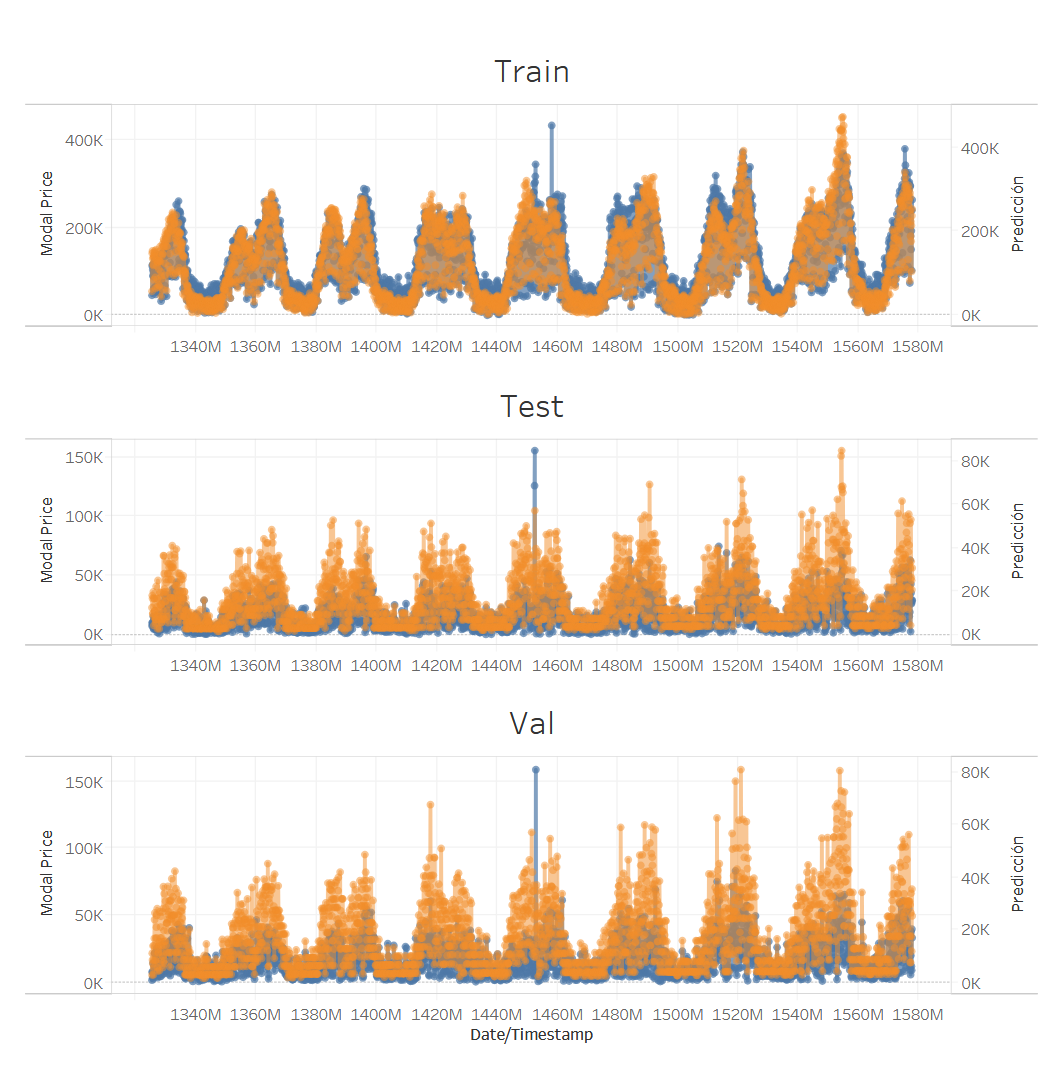

El dashboard también presenta métricas de desempeño para cada dataset.

Es raro de observar en muchos problemas pero en este caso presenta un error menor en el dataset de validation respecto al de entrenamiento y pruebas, y los datos de validación son explicados por nuestro modelo en un punto porcentual más respecto a los otros datasets. Comunmente los modelos tienen un mejor ajuste a los datos de entrenamiento, pero aquí se presenta el caso contrario.

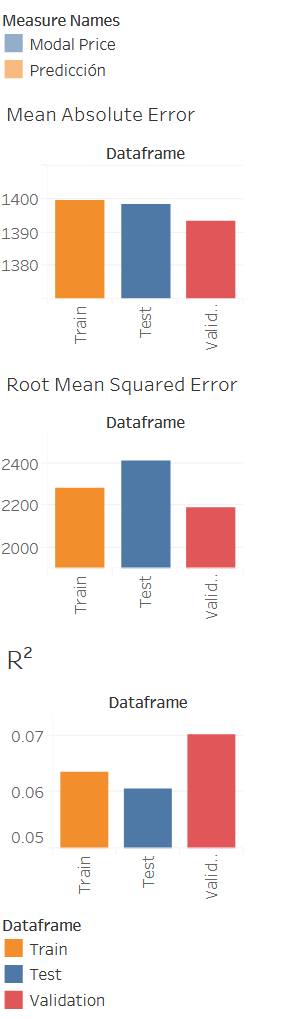